# Decoding Medical Bills: A Predictive Model for Individual Health Expenses

In this analysis, our primary objective is to understand the relationship between individual characteristics and their total medical costs, utilizing the Medical Cost Data Set from Kaggle. The dataset provides insights into the medical bills of individuals, accompanied by various demographic and personal attributes. Our goal is to develop a predictive model that accurately estimates medical costs based on these characteristics, aiding hospitals in revenue prediction and procedural planning.

We adopted a systematic approach beginning with an exploratory analysis to identify the most influential variables correlating with medical costs. Focusing on age, BMI, and smoking status, we employed a linear regression model to decipher their impacts on medical expenses. Initial residual analysis indicated signs of non-randomness, prompting the integration of second-degree polynomial features to enhance the model’s performance and accuracy.

The refined polynomial model demonstrated a marked reduction in heteroscedasticity and non-linearity, resulting in more reliable and consistent predictions. Evaluation on the test data yielded an R-squared value of 0.76, indicative of a robust model capturing a significant portion of the variance in medical costs. The RMSE of USD 5,700 further underscores the model’s precision in predicting individual medical costs, offering a valuable tool for healthcare financial planning and resource allocation.

In [52]:
import pandas as pd
import numpy as np

In [53]:
insurance = pd.read_csv('insurance.csv')

insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Exploratory Data Analysis

In [54]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


No values are missing.

In [55]:
insurance['sex'].value_counts(dropna=False)

male      676
female    662
Name: sex, dtype: int64

In [56]:
insurance['smoker'].value_counts(dropna=False)

no     1064
yes     274
Name: smoker, dtype: int64

We'll transform sex and smoker columns into binary.

In [57]:
# Transforming columns to binary
insurance['sex'] = insurance['sex'].apply(lambda x: 0 if x=='male' else 1)

insurance['smoker'] = insurance['smoker'].apply(lambda x: 0 if x=='no' else 1)

In [58]:
insurance['region'].value_counts(dropna=False)

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

We'll transform region column into binary as well using dummy variables.

In [59]:
# Adding dummy columns for region
insurance_1 = pd.get_dummies(insurance, drop_first=True).copy()

insurance_1

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,0,0,1
1,18,0,33.770,1,0,1725.55230,0,1,0
2,28,0,33.000,3,0,4449.46200,0,1,0
3,33,0,22.705,0,0,21984.47061,1,0,0
4,32,0,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,10600.54830,1,0,0
1334,18,1,31.920,0,0,2205.98080,0,0,0
1335,18,1,36.850,0,0,1629.83350,0,1,0
1336,21,1,25.800,0,0,2007.94500,0,0,1


In [60]:
insurance_1.describe()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.204783,13270.422265,0.242900,0.272048,0.242900
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,0.428995,0.445181,0.428995
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,0.000000,0.000000,0.000000
50%,39.000000,0.000000,30.400000,1.000000,0.000000,9382.033000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,0.000000,1.000000,0.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010,1.000000,1.000000,1.000000


Observations are equally distributed in relation to sex and region; 80% of clients do not smoke.

We'll inspect visually the distribution of age, bmi, children variable, as well as target variable charges.

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

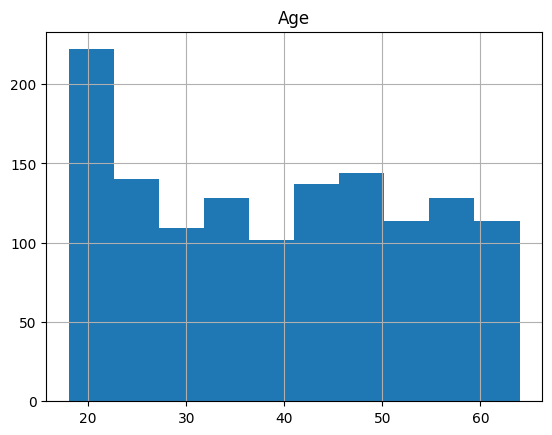

In [62]:
insurance_1['age'].hist()
plt.title('Age')
plt.show()

The distribution of age is strongly skewed towards younger population.

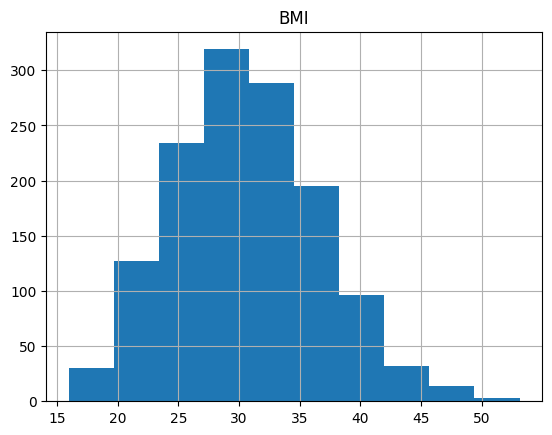

In [63]:
insurance_1['bmi'].hist()
plt.title('BMI')
plt.show()

The Body Mass Index (BMI) has a close to normal distribution around the mean.

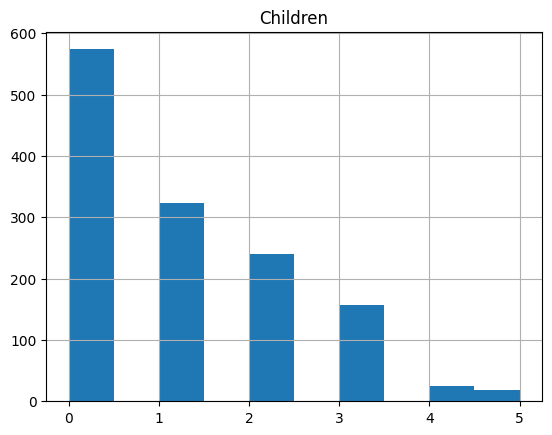

In [64]:
insurance_1['children'].hist()
plt.title('Children')
plt.show()

The distribution of the number of children is strognly skewed towards zero.

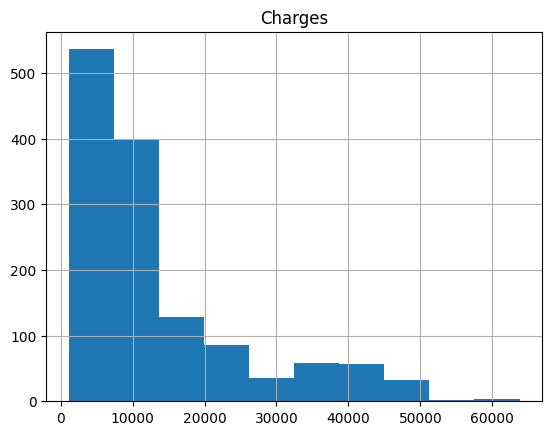

In [65]:
insurance_1['charges'].hist()
plt.title('Charges')
plt.show()

The distribution of the target variable looks skewed to the right, with amount of charge being mostly below 20k.

Next we will explore the correlations among variables.

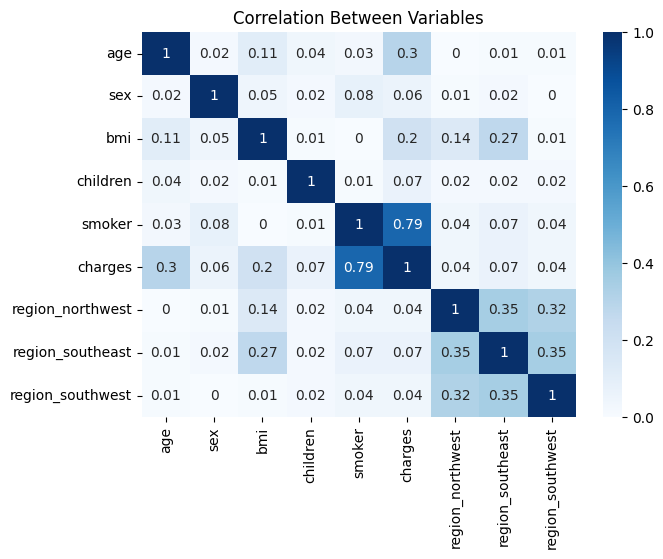

In [66]:
# Plotting the pairwise correlations' heatmap
plt.figure(figsize=(7,5))

sns.heatmap(abs(round(insurance_1.corr(), 2)), cmap='Blues', annot=True)

plt.title('Correlation Between Variables')

plt.show()

The charges show strong correlation with smoker variable, and might be also affected by age and bmi.

We will make a scatter plot for these variables.

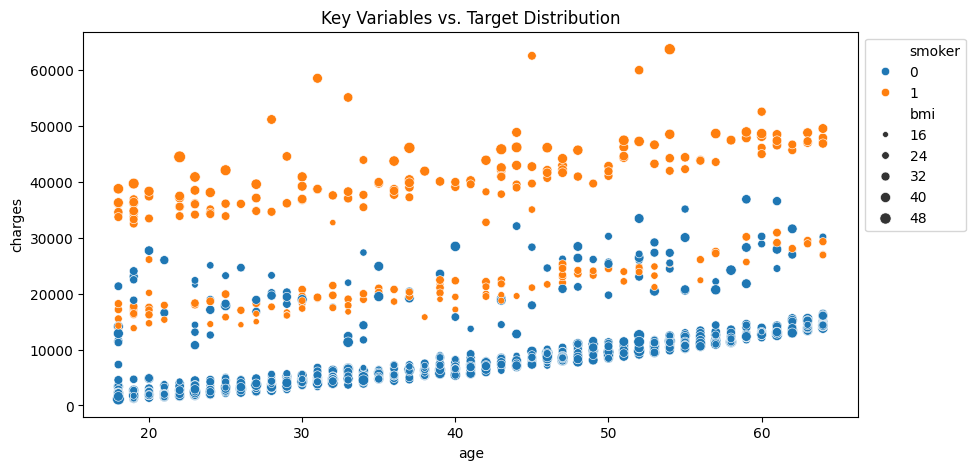

In [67]:
plt.figure(figsize=(10,5))

ax = sns.scatterplot(x='age', y='charges',
               hue='smoker', size='bmi',
               data=insurance,
                palette='tab10')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Key Variables vs. Target Distribution')

plt.show()

Based on the scatter plot, the amount of charge is positively correlated with a person being a smoker, older age and higher bmi.

## Selecting the Variables

We will focus on age, smoker, and BMI for our analysis.

We will check for multicollinearity using VIF.

In [68]:
# Selecting the variables
X = insurance_1[['age', 'smoker', 'bmi']].copy()

# Selecting the target
y = insurance_1['charges'].copy()

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data['variable'] = X.columns

vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,variable,VIF
0,age,7.458655
1,smoker,1.246501
2,bmi,7.667212


There are signs of multicollinearity between age and bmi. To mitigate it, we can either include an interaction term bmi x age, or exlude bmi. We will fit 2 models, with the interaction term and without bmi, and check which one is more accurate.

In [70]:
X['age_bmi'] = X['age'] * X['bmi']

In [71]:
# Importing functions for the modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=700)

In [73]:
X_train

,age,smoker,bmi,age_bmi
69,28,1,23.980,671.44
1171,43,1,26.700,1148.10
843,57,1,29.810,1699.17
1133,52,0,18.335,953.42
239,44,0,38.060,1674.64
...,...,...,...,...
177,54,0,29.200,1576.80
446,60,0,29.640,1778.40
1159,32,0,41.100,1315.20
891,36,0,29.040,1045.44


## Fitting the Model

In [74]:
# Fitting Model 1 (with the interaction term)
model_1 = LinearRegression()

model_1.fit(X_train, y_train)

y_predict_1 = model_1.predict(X_train)

# Calculating RMSE and R squared
rmse_1 = mean_squared_error(y_train, y_predict_1, squared=False)

R2_1 = r2_score(y_train,  y_predict_1)

print(' Model 1 (age, smoker, bmi, age x bmi) coefficients:', model_1.coef_,
     '\n',
     'intercept:', model_1.intercept_,
     '\n',
     'R squared:', round(R2_1, 2),
     '\n',
     'RMSE:', round(rmse_1, 2))

 Model 1 (age, smoker, bmi, age x bmi) coefficients: [2.02490259e+02 2.38040246e+04 2.82408224e+02 1.59673171e+00] 
 intercept: -10255.972706385859 
 R squared: 0.76 
 RMSE: 5933.61


In [75]:
X_train_2 = X_train.drop(['bmi', 'age_bmi'], axis=1)

# Fitting Model 2 (without bmi)
model_2 = LinearRegression()

model_2.fit(X_train_2, y_train)

y_predict_2 = model_2.predict(X_train_2)

# Calculating RMSE and R squared
rmse_2 = mean_squared_error(y_train, y_predict_2, squared=False)

R2_2 = r2_score(y_train,  y_predict_2)

print(' Model 2 (age, smoker) coefficients:', model_2.coef_,
     '\n',
     'intercept:', model_2.intercept_,
     '\n',
     'R squared:', round(R2_2, 2),
     '\n',
     'RMSE:', round(rmse_2, 2))

 Model 2 (age, smoker) coefficients: [  268.76020525 23815.8122579 ] 
 intercept: -2300.380324933132 
 R squared: 0.73 
 RMSE: 6281.06


Based on training set performance, Model 1, which includes both bmi and age * bmi interaction, looks slightly better, with lower RMSE and higher R squared.

Next we will compare how well the models perform on the test data.

In [76]:
X_test_2 = X_test.drop(['bmi', 'age_bmi'], axis=1)

# Calculating predicted values
y_pred_test_1 = model_1.predict(X_test)
y_pred_test_2 = model_2.predict(X_test_2)

# Calculating RMSE
rmse_test_1 = mean_squared_error(y_test, y_pred_test_1, squared=False)
rmse_test_2 = mean_squared_error(y_test, y_pred_test_2, squared=False)

# Calculating R squared
R2_test_1 = r2_score(y_test,  y_pred_test_1)
R2_test_2 = r2_score(y_test,  y_pred_test_2)

In [77]:
print(' Model 1 on test data, R squared:', round(R2_test_1, 2),
     '\n',
     'RMSE:', round(rmse_test_1, 2))

 Model 1 on test data, R squared: 0.68 
 RMSE: 6666.04


In [78]:
print(' Model 2 on test data, R squared:', round(R2_test_2, 2),
     '\n',
     'RMSE:', round(rmse_test_2, 2))

 Model 2 on test data, R squared: 0.66 
 RMSE: 6817.34


Since we are interested in predicting the charge amount, we will stick with a Model 1 that has higher R squared and RMSE, even though it somewhat lacks in interpretability.

## Residual Analysis

Next we will explore the residuals for normality and heteroscedasticity.

In [79]:
residuals_1 = y_train - y_predict_1

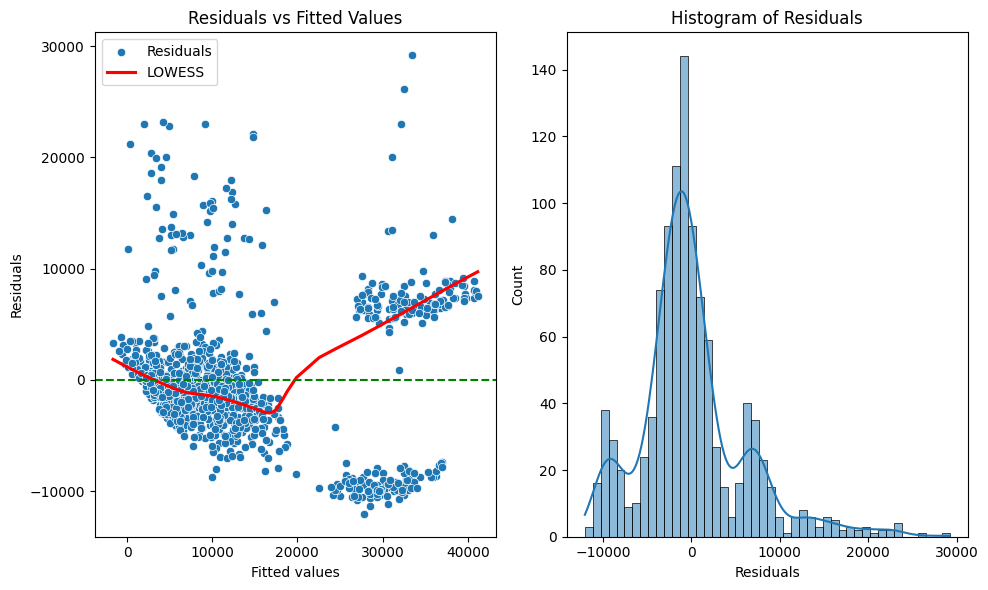

In [80]:
# Plotting residuals
plt.figure(figsize=(10,6))

# Residual scatter plot
plt.subplot(1, 2, 1)

sns.scatterplot(x=y_predict_1, y=residuals_1, label='Residuals')
sns.regplot(x=y_predict_1, y=residuals_1, lowess=True, scatter=False, label='LOWESS', line_kws={'color': 'red'})
plt.axhline(y=0, color='g', linestyle='--')

plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.legend()

# Histogram of residuals
plt.subplot(1, 2, 2)

sns.histplot(residuals_1, kde=True)

plt.xlabel('Residuals')
plt.title('Histogram of Residuals')

plt.tight_layout()
plt.show()

We can note several things:
- Non-random Pattern:
The residuals do not appear to be randomly distributed. There is a clear pattern, which suggests that the model has not captured all the underlying patterns in the data.
- Potential Heteroscedasticity:
The spread of the residuals seems to change across the range of fitted values, which might indicate heteroscedasticity.
- Non-linearity:
The visible pattern in the residuals might suggest that the relationship between the predictors and the response variable is non-linear.

We will try to stabilize the model with the help of polynomial features.

In [81]:
from sklearn.preprocessing import PolynomialFeatures

# Creating 2nd degree polynomial
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X[['age', 'smoker', 'bmi']])

X_poly

array([[1.0000000e+00, 1.9000000e+01, 1.0000000e+00, ..., 1.0000000e+00,
        2.7900000e+01, 7.7841000e+02],
       [1.0000000e+00, 1.8000000e+01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.1404129e+03],
       [1.0000000e+00, 2.8000000e+01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0890000e+03],
       ...,
       [1.0000000e+00, 1.8000000e+01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.3579225e+03],
       [1.0000000e+00, 2.1000000e+01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 6.6564000e+02],
       [1.0000000e+00, 6.1000000e+01, 1.0000000e+00, ..., 1.0000000e+00,
        2.9070000e+01, 8.4506490e+02]])

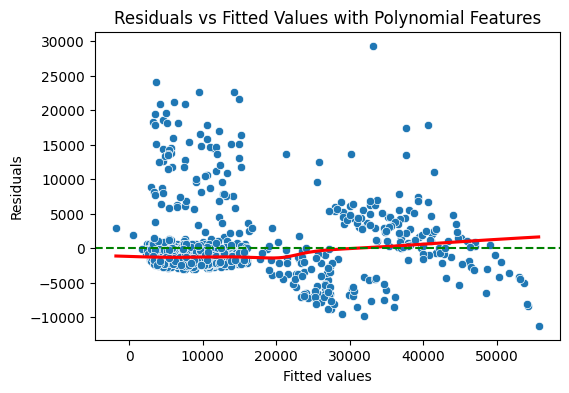

In [82]:
# Splitting data into training and testing sets with polynomial features
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=700)

# Fitting the model with polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train_poly)

# Calculating residuals with polynomial features
y_pred_poly_train = model_poly.predict(X_train_poly)
residuals_poly = y_train_poly - y_pred_poly_train

# Plotting the residuals with polynomial features
plt.figure(figsize=(6, 4))

sns.scatterplot(x=y_pred_poly_train, y=residuals_poly)
sns.regplot(x=y_pred_poly_train, y=residuals_poly, lowess=True, scatter=False, line_kws={'color': 'red'})
plt.axhline(y=0, color='g', linestyle='--')

plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values with Polynomial Features')

plt.show()

The residuals are more randomly dispersed around the horizontal line, suggesting that the model is now capturing a greater extent of the underlying patterns in the data.
The spread of residuals appears more constant across different levels of fitted values, indicating a reduction in heteroscedasticity.
The absence of a clear pattern in the residuals suggests that non-linearity issues have been addressed to some extent.

We will not use higher-degree polynomials to avoid potential overfitting.

We can additionally check for normality of residual using QQ plot.

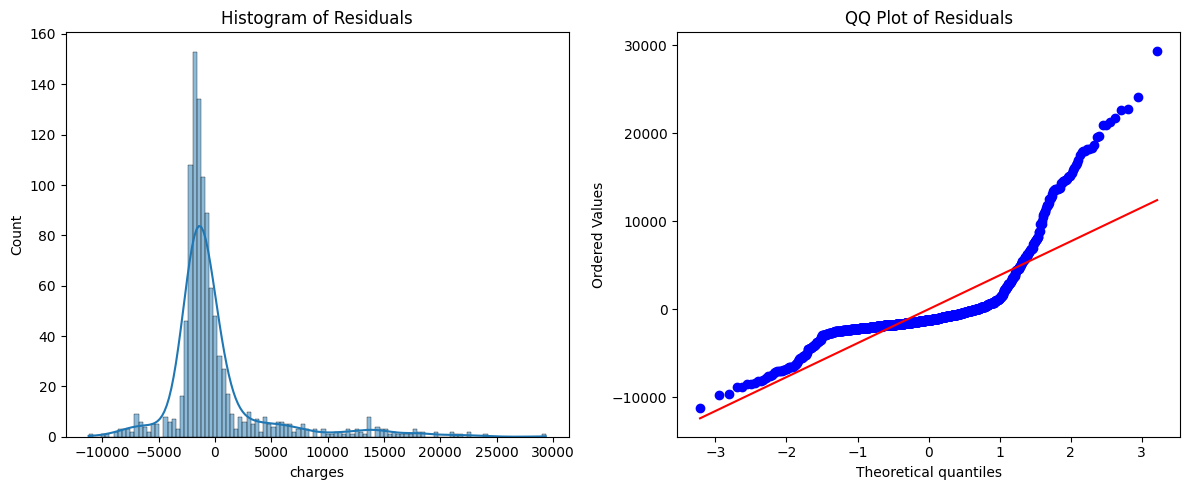

In [83]:
import scipy.stats as stats

# Plotting histogram and QQ plot of the improved residuals
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(residuals_poly, kde=True)
plt.title('Histogram of Residuals')

# QQ plot
plt.subplot(1, 2, 2)
stats.probplot(residuals_poly, plot=plt)
plt.title('QQ Plot of Residuals')

plt.tight_layout()
plt.show()

The points in the central section of the plot are closely aligned with the theoretical line, indicating that the central portion of the data is approximately normally distributed.

Now we can check the accuracy of the revised model.

In [84]:
# Calculating RMSE and R squared
rmse_poly_train = mean_squared_error(y_train_poly, y_pred_poly_train, squared=False)

R2_poly_train = r2_score(y_train_poly,  y_pred_poly_train)

print(' Model 3 coefficients:', model_poly.coef_,
     '\n',
     'intercept:', model_poly.intercept_,
     '\n',
     'R squared:', round(R2_poly_train, 2),
     '\n',
     'RMSE:', round(rmse_poly_train, 2))

 Model 3 coefficients: [ 0.00000000e+00  3.99275022e+01 -1.04311822e+04  5.16686710e+02
  1.91845871e+00 -6.48943480e+00  2.30557259e+00 -1.04311822e+04
  1.47072497e+03 -9.48327986e+00] 
 intercept: -6038.527112615313 
 R squared: 0.86 
 RMSE: 4615.49


The model lacks in interpretability, but shows better accuracy, which is an adequate trade-off given the goal of our analysis.

## Model Evaluation

We will check the predictive power of the polynomial model on test data.

In [85]:
y_pred_poly_test = model_poly.predict(X_test_poly)

# Calculating RMSE and R squared on the test data
rmse_poly_test = mean_squared_error(y_test_poly, y_pred_poly_test, squared=False)

R2_poly_test = r2_score(y_test_poly,  y_pred_poly_test)

print(' Model 3 evaluated on test data:',
      '\n',
     'R squared:', round(R2_poly_test, 2),
     '\n',
     'RMSE:', round(rmse_poly_test, 2))

 Model 3 evaluated on test data: 
 R squared: 0.76 
 RMSE: 5744.54


Our 2nd degree polynomial model shows decent accuracy on new data, and can be expected to explain around 76% of the target variable variance. On average the model's predictions will be USD 5,7k away from the actual value of charges.

# Conclusion

In this analysis, our focus was to unravel the complex relationship between individual characteristics and medical costs, utilizing a detailed dataset. We aimed to construct a predictive model that could accurately estimate individual medical bills, a tool of significant value to hospitals for financial planning and resource allocation. The approach involved an in-depth exploration of the dataset, with a particular emphasis on variables like age, BMI, and smoking status, and employing a linear regression model enhanced with polynomial features to optimize predictions.

Our findings revealed a marked improvement in prediction accuracy with the integration of second-degree polynomial features, addressing initial challenges of heteroscedasticity and non-linearity. The final model, evaluated on test data, yielded a commendable R-squared value of 0.76 and an RMSE of USD 5,700. These metrics underscore the model's effectiveness in capturing a significant portion of the variance in medical costs and its precision in estimation. While the model is robust, we recognize the continual need for refinement and adaptation to broader and more diverse datasets to enhance its applicability and accuracy further.